In [ ]:
#default_exp gt
from nbdev.showdoc import show_doc, add_docs

# Ground Truth Estimation

> Implements functions for ground truth estimation from the annotations of multiple experts. Based on [SimpleITK](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/34_Segmentation_Evaluation.html).

In [ ]:
#hide 
from deepflash2.utils import download_sample_data
import shutil
from fastcore.test import *

In [ ]:
#export
import imageio, pandas as pd, numpy as np
from pathlib import Path
from fastcore.basics import GetAttr
from fastprogress import progress_bar
from fastai.data.transforms import get_image_files

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from deepflash2.data import _read_msk
from deepflash2.config import Config
from deepflash2.utils import save_mask, dice_score, install_package, get_instance_segmentation_metrics

In [ ]:
# Download test data
exp_dir = Path('gt_tmp')
url = 'https://github.com/matjesg/deepflash2/releases/download/sample_data/'
download_sample_data(url, 'wue1_cFOS_expert_segmentation_samples.zip', exp_dir , extract=True)
files=['0004_mask.png', '0001_mask.png']
experts = [f'expert_{i}' for i in range(1,6)]

## Helper Functions

Installing [SimpleITK](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/34_Segmentation_Evaluation.html), which is not a dependency of `deepflash2`.

In [ ]:
#export
def import_sitk():
    try:
        import SimpleITK
        assert SimpleITK.Version_MajorVersion()==2
    except:
        print('Installing SimpleITK. Please wait.')
        install_package("SimpleITK==2.0.2")
    import SimpleITK
    return SimpleITK

In [ ]:
# Test import
import_sitk();

## Ground Truth Estimation

### Simultaneous truth and performance level estimation (STAPLE) 

The STAPLE algorithm considers a collection of segmentations and computes a probabilistic estimate of the true segmentation and a measure of the performance level represented by each segmentation. 

_Source: Warfield, Simon K., Kelly H. Zou, and William M. Wells. "Simultaneous truth and performance level estimation (STAPLE): an algorithm for the validation of image segmentation." IEEE transactions on medical imaging 23.7 (2004): 903-921_

In [ ]:
##export
def staple(segmentations, foregroundValue = 1, threshold = 0.5):
    'STAPLE: Simultaneous Truth and Performance Level Estimation with simple ITK'
    sitk = import_sitk()
    segmentations = [sitk.GetImageFromArray(x) for x in segmentations]
    STAPLE_probabilities = sitk.STAPLE(segmentations)
    STAPLE = STAPLE_probabilities > threshold
    #STAPLE = sitk.GetArrayViewFromImage(STAPLE)
    return sitk.GetArrayFromImage(STAPLE)

In [ ]:
#export
def staple_multi_label(segmentations, label_undecided_pixel=1):
    'STAPLE: Simultaneous Truth and Performance Level Estimation with simple ITK'
    sitk = import_sitk()
    sitk_segmentations = [sitk.GetImageFromArray(x) for x in segmentations]
    STAPLE = sitk.MultiLabelSTAPLEImageFilter()
    STAPLE.SetLabelForUndecidedPixels(label_undecided_pixel)
    msk = STAPLE.Execute(sitk_segmentations)
    return sitk.GetArrayFromImage(msk)

In [ ]:
# Test if staple multi has the same results as staple
for f in files:
    for i in range(3,7):
        experts = [f'expert_{j}' for j in range(1,i)]
        segmentations = [_read_msk(exp_dir/exp/f) for exp in experts]
        out_staple = staple(segmentations)
        out_staple_multi = staple_multi_label(segmentations)
        test_eq(out_staple, out_staple_multi)

### Majority Voting
Use majority voting to obtain the reference segmentation. Note that this filter does not resolve ties. In case of ties it will assign the backgtound label (0) to the result. 

In [ ]:
#export
def m_voting(segmentations, labelForUndecidedPixels = 0):
    'Majority Voting from  simple ITK Label Voting'
    sitk = import_sitk()
    segmentations = [sitk.GetImageFromArray(x) for x in segmentations]
    mv_segmentation = sitk.LabelVoting(segmentations, labelForUndecidedPixels)
    return sitk.GetArrayFromImage(mv_segmentation)

### GT Estimator

Class for ground truth estimation

In [ ]:
#export
def msk_show(ax, msk, title, cmap, cbar=None, ticks=None, **kwargs):
    img = ax.imshow(msk, cmap=cmap, **kwargs)
    if cbar is not None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        if cbar=='plot': 
            scale = ticks/(ticks+1)
            cbr = plt.colorbar(img, cax=cax, ticks=[i*(scale)+(scale/2) for i in range(ticks+1)])
            cbr.set_ticklabels([i for i in range(ticks+1)])
            cbr.set_label('# of experts', rotation=270, labelpad=+15, fontsize="larger")
        elif cbar=='classes': 
            scale = ticks/(ticks)
            bounds = [i for i in range(ticks+1)]
            cmap = plt.cm.get_cmap(cmap)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='neither')
            cbr = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                               cax=cax, ticks=[i*(scale)+(scale/2) for i in range(ticks)])
            cbr.set_ticklabels([i for i in range(ticks)])
            cbr.set_label('Classes', rotation=270, labelpad=+15, fontsize="larger")
        else: cax.set_axis_off()
    ax.set_axis_off()
    ax.set_title(title)            

In [ ]:
#export
class GTEstimator(GetAttr):
    "Class for ground truth estimation"
    _default = 'config' 
    
    def __init__(self, exp_dir='expert_segmentations', config=None, path=None, cmap='viridis' , verbose=1):
        self.exp_dir = exp_dir
        self.config = config or Config()
        self.path = Path(path) if path is not None else Path('.')
        self.mask_fn = lambda exp,msk: self.path/self.exp_dir/exp/msk
        self.cmap = cmap
        self.gt = {}
        
        f_list = get_image_files(self.path/self.exp_dir)
        assert len(f_list)>0, f'Found {len(f_list)} masks in "{self.path/self.exp_dir}". Please check your masks and expert folders.'
        ass_str = f'Found unexpected folder structure in {self.path/self.exp_dir}. Please check your provided masks and folders.'
        assert len(f_list[0].relative_to(self.path/self.exp_dir).parents)==2, ass_str
              
        self.masks = {}
        self.experts = []
        for m in sorted(f_list):
            exp = m.parent.name
            if m.name in self.masks:
                self.masks[m.name].append(exp)
            else:
                self.masks[m.name] = [exp]
            self.experts.append(exp)
        self.experts = sorted(set(self.experts))
        if verbose>0: print(f'Found {len(self.masks)} unique segmentation mask(s) from {len(self.experts)} expert(s)')
                   
    def show_data(self, max_n=6, files=None, figsize=None, **kwargs):
        if files is not None:
            files = [(m,self.masks[m]) for m in files]
        else:
            max_n = min((max_n, len(self.masks)))
            files = list(self.masks.items())[:max_n]
        if not figsize: figsize = (len(self.experts)*3,3)
        for m, exps in files:
            fig, axs = plt.subplots(nrows=1, ncols=len(exps), figsize=figsize, **kwargs)
            vkwargs = {'vmin':0, 'vmax':self.num_classes-1}
            for i, exp in enumerate(exps):
                msk = _read_msk(self.mask_fn(exp,m), num_classes=self.num_classes, instance_labels=self.instance_labels)
                if i == len(exps) - 1:
                    msk_show(axs[i], msk, exp, self.cmap, cbar='classes', ticks=self.num_classes, **vkwargs)
                else: 
                    msk_show(axs[i], msk, exp, self.cmap, **vkwargs)
            fig.text(0, .5, m, ha='center', va='center', rotation=90)
            plt.tight_layout()
            plt.show()
    
    def gt_estimation(self, method='STAPLE', save_dir=None, filetype='.png', **kwargs):
        assert method in ['STAPLE', 'majority_voting']
        res = []
        refs = {}
        print(f'Starting ground truth estimation - {method}')
        for m, exps in progress_bar(self.masks.items()):
            masks = [_read_msk(self.mask_fn(exp,m), num_classes=self.num_classes, instance_labels=self.instance_labels) for exp in exps]
            if method=='STAPLE': 
                #ref = staple(masks, self.staple_fval, self.staple_thres)
                ref = staple_multi_label(masks, self.vote_undec)
            elif method=='majority_voting':
                ref = m_voting(masks, self.vote_undec)
            refs[m] = ref
            #assert ref.mean() > 0, 'Please try again!'
            df_tmp = pd.DataFrame({'method': method, 'file' : m, 'exp' : exps, 'dice_score': [dice_score(ref, msk, num_classes=self.num_classes) for msk in masks]})
            if self.instance_segmentation_metrics: 
                mAP, AP = [],[]
                for msk in masks:
                    ap, tp, fp, fn = get_instance_segmentation_metrics(ref, msk, is_binary=True, **kwargs)
                    mAP.append(ap.mean())
                    AP.append(ap[0])
                df_tmp['mean_average_precision'] = mAP
                df_tmp['average_precision_at_iou_50'] = AP
            res.append(df_tmp)
            if save_dir:  
                path = self.path/save_dir
                path.mkdir(exist_ok=True, parents=True)
                save_mask(ref, path/Path(m).stem, filetype)
        self.gt[method] = refs
        self.df_res = pd.concat(res)
        self.df_agg = self.df_res.groupby('exp').agg(average_dice_score=('dice_score', 'mean'), std_dice_score=('dice_score', 'std'))
        if self.instance_segmentation_metrics: 
            self.df_agg = self.df_res.groupby('exp').agg(average_dice_score=('dice_score', 'mean'), 
                                                         std_dice_score=('dice_score', 'std'),
                                                         average_mean_average_precision=('mean_average_precision', 'mean'), 
                                                         std_mean_average_precision=('mean_average_precision', 'std'),
                                                         average_average_precision_at_iou_50=('average_precision_at_iou_50', 'mean'), 
                                                         std_average_precision_at_iou_50=('average_precision_at_iou_50', 'std'))
        if save_dir: 
            self.df_res.to_csv(path.parent/f'{method}_vs_experts.csv', index=False)
            self.df_agg.to_csv(path.parent/f'{method}_vs_experts_agg.csv', index=False)
            with pd.ExcelWriter(path.parent/f'{method}_vs_experts.xlsx') as writer:  
                self.df_res.to_excel(writer, sheet_name='raw')
                self.df_agg.to_excel(writer, sheet_name='aggregated')
            
    def show_gt(self, method='STAPLE', max_n=6, files=None, figsize=(15,7), **kwargs):
        from IPython.display import Markdown, display
        if not files: files = list(self.masks.keys())[:max_n]
        for f in files:
            if self.num_classes==2:
                fig, ax = plt.subplots(ncols=2, figsize=figsize, **kwargs)
                # GT
                msk_show(ax[0], self.gt[method][f], f'{method} (binary mask)', cbar='', cmap=self.cmap)
                # Experts
                masks = [_read_msk(self.mask_fn(exp,f), num_classes=self.num_classes, instance_labels=self.instance_labels) for exp in self.masks[f]]
                masks_av = np.array(masks).sum(axis=0)#/len(masks)
                msk_show(ax[1], masks_av, 'Expert Overlay', cbar='plot', ticks=len(masks), cmap=plt.cm.get_cmap(self.cmap, len(masks)+1))
            else:
                fig, ax = plt.subplots(ncols=1, figsize=figsize, **kwargs)
                msk_show(ax, self.gt[method][f], f'{method}', cbar='classes', cmap=self.cmap, ticks=self.num_classes)
            # Results
            metrics = ['dice_score', 'mean_average_precision', 'average_precision_at_iou_50'] if self.instance_segmentation_metrics else ['dice_score']  
            av_df = pd.DataFrame([self.df_res[self.df_res.file==f][metrics].mean()], index=['average'], columns=metrics)
            plt_df = self.df_res[self.df_res.file==f].set_index('exp')[metrics].append(av_df)
            fig.text(0, .5, f, ha='center', va='center', rotation=90)
            plt.tight_layout()
            plt.show()
            display(plt_df)
            display(Markdown('---'))

In [ ]:
t = GTEstimator(exp_dir=exp_dir, config=Config(instance_segmentation_metrics=True));

Found 5 unique segmentation mask(s) from 6 expert(s)


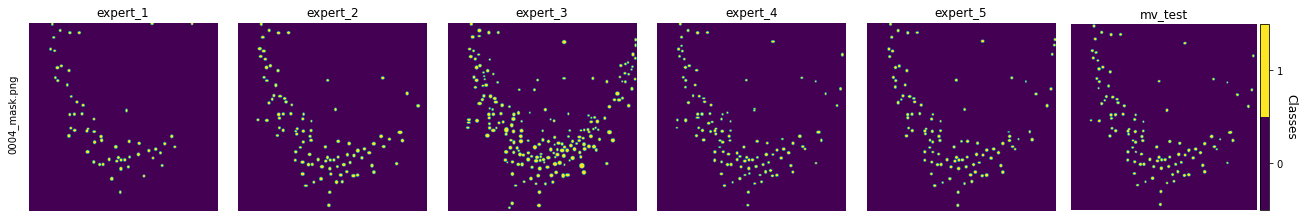

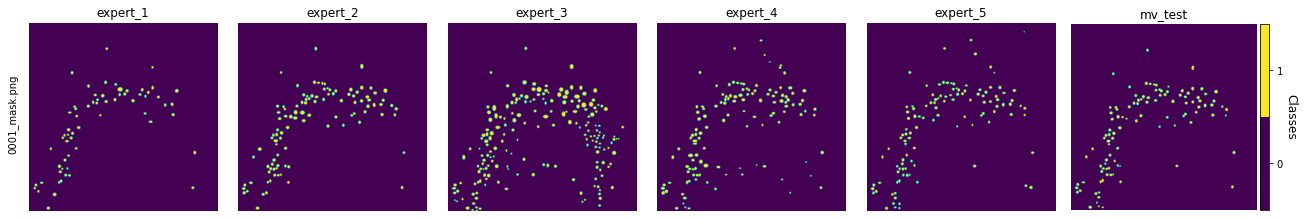

In [ ]:
t.show_data(files=files);

Starting ground truth estimation - STAPLE


2022-06-07 11:31:56,372 [INFO] WRITING LOG OUTPUT TO /home/magr/.cellpose/run.log


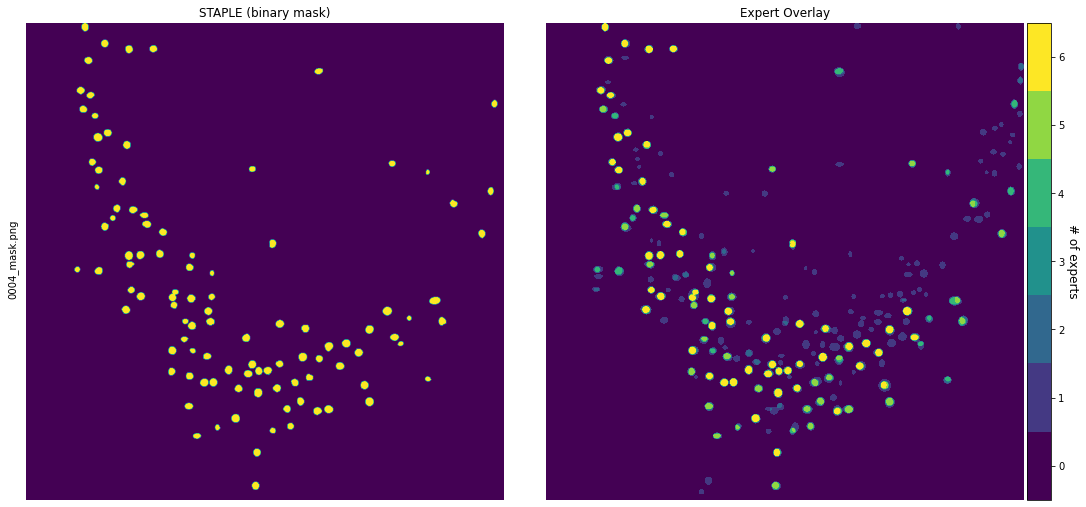

,dice_score,mean_average_precision,average_precision_at_iou_50
expert_1,0.676638,0.341097,0.538462
expert_2,0.845505,0.469134,0.833333
expert_3,0.591542,0.169529,0.390698
expert_4,0.861491,0.543565,0.846154
expert_5,0.893066,0.647050,0.863636
mv_test,1.000000,1.000000,1.000000
average,0.811374,0.528396,0.745380


---

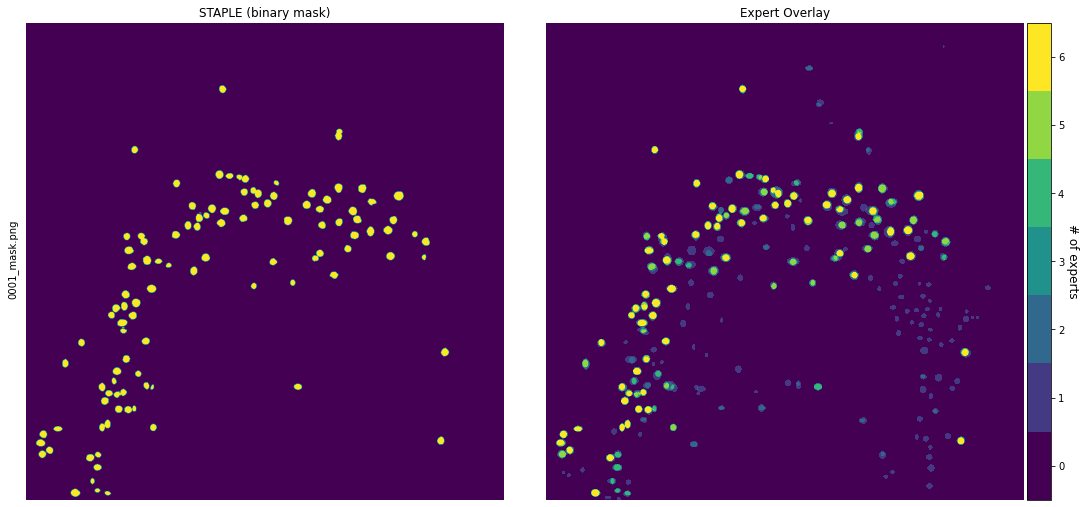

,dice_score,mean_average_precision,average_precision_at_iou_50
expert_1,0.710698,0.314402,0.532110
expert_2,0.837439,0.398583,0.699187
expert_3,0.619365,0.169128,0.391509
expert_4,0.805809,0.416399,0.632353
expert_5,0.860788,0.450650,0.786885
mv_test,1.000000,1.000000,1.000000
average,0.805683,0.458194,0.673674


---

In [ ]:
t.gt_estimation()
t.show_gt(files=files)

Starting ground truth estimation - majority_voting


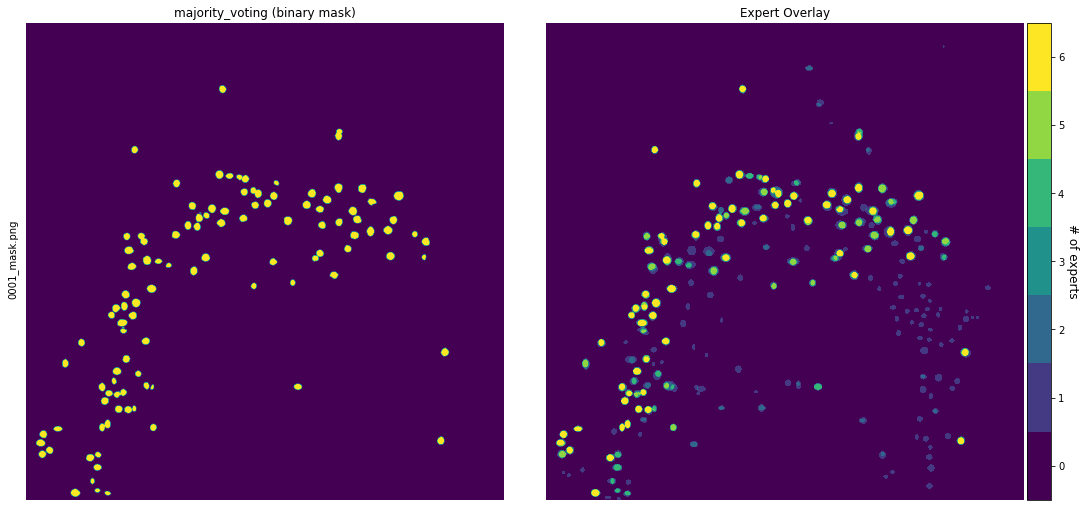

,dice_score,mean_average_precision,average_precision_at_iou_50
expert_1,0.710698,0.314402,0.532110
expert_2,0.837439,0.398583,0.699187
expert_3,0.619365,0.169128,0.391509
expert_4,0.805809,0.416399,0.632353
expert_5,0.860788,0.450650,0.786885
mv_test,1.000000,1.000000,1.000000
average,0.805683,0.458194,0.673674


---

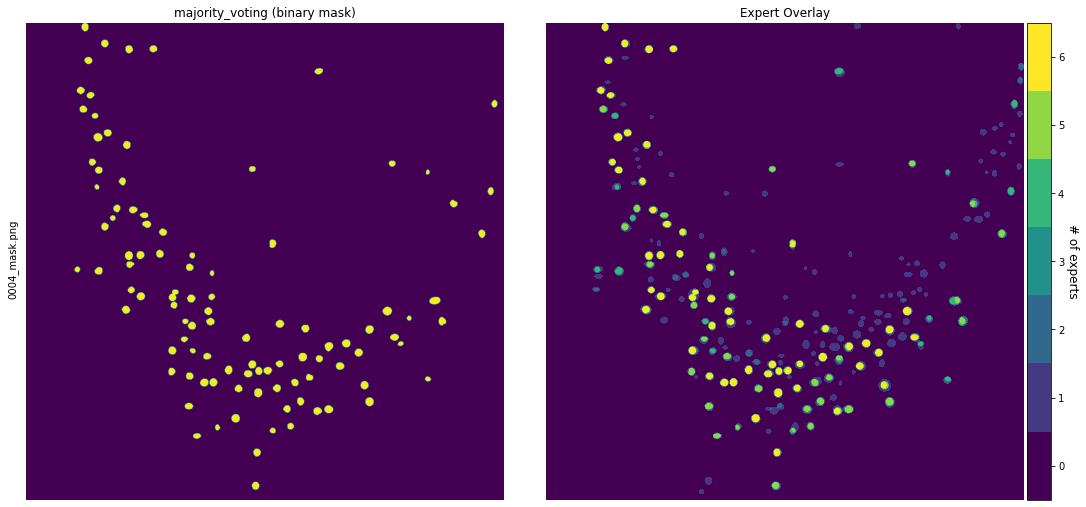

,dice_score,mean_average_precision,average_precision_at_iou_50
expert_1,0.676638,0.341097,0.538462
expert_2,0.845505,0.469134,0.833333
expert_3,0.591542,0.169529,0.390698
expert_4,0.861491,0.543565,0.846154
expert_5,0.893066,0.647050,0.863636
mv_test,1.000000,1.000000,1.000000
average,0.811374,0.528396,0.745380


---

In [ ]:
t.gt_estimation(method='majority_voting', save_dir=exp_dir/'mv_test')
t.show_gt(method='majority_voting', max_n=2)

In [ ]:
shutil.rmtree(exp_dir)

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_config.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 03_learner.ipynb.
Converted 04_inference.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted 07_tta.ipynb.
Converted 08_gui.ipynb.
Converted 09_gt.ipynb.
Converted add_information.ipynb.
Converted index.ipynb.
Converted model_library.ipynb.
Converted tutorial.ipynb.
Converted tutorial_gt.ipynb.
Converted tutorial_pred.ipynb.
Converted tutorial_train.ipynb.
